In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


## 1. Leer los archivos y extraer features

In [2]:
# Carpeta de eventos y no eventos
#path_eventos = './Eventos'
#path_no_eventos = './No_eventos'

path_eventos = './Events'
path_no_eventos = './Non_Events'

# Función para extraer características de un archivo
def extraer_features(df):
    features = []
    for col in df.columns:
        datos = df[col].values
        features.extend([
            np.mean(datos),
            np.std(datos),
            np.min(datos),
            np.max(datos),
            np.percentile(datos, 75) - np.percentile(datos, 25),  # IQR
            np.sum(np.square(datos)),  # Energía
        ])
    return features

# Cargar datos con extracción de características
def cargar_y_transformar(path, etiqueta):
    X = []
    y = []
    for archivo in os.listdir(path):
        if archivo.endswith('.csv'):
            df = pd.read_csv(os.path.join(path, archivo))
            X.append(extraer_features(df))
            y.append(etiqueta)
    return X, y

X_eventos, y_eventos = cargar_y_transformar(path_eventos, 1)
X_no_eventos, y_no_eventos = cargar_y_transformar(path_no_eventos, 0)

# Unir y convertir en arrays
X = np.array(X_eventos + X_no_eventos)
y = np.array(y_eventos + y_no_eventos)

print("Forma final de X:", X.shape)
print("Total muestras:", len(y))


Forma final de X: (910, 36)
Total muestras: 910


## 2. Dividir y escalar datos.

In [3]:
# División
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Tamaño X_train:", X_train.shape)
print("Tamaño y_train:", y_train.shape)
print("Etiquetas únicas:", np.unique(y_train, return_counts=True))
print("Contiene NaNs:", np.isnan(X_train).any())
print(X_train.shape)

Tamaño X_train: (637, 36)
Tamaño y_train: (637,)
Etiquetas únicas: (array([0, 1]), array([319, 318], dtype=int64))
Contiene NaNs: False
(637, 36)


## 3. Prueba de diferentes configuraciones de SVM y evalua.

### RandomizedSearchCV

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

param_dist = {
    'C': np.linspace(2, 5, 100),  # valores entre 0.01 y 100
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

scorer = make_scorer(f1_score, average='macro')
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

svm = SVC(probability=True)

random_search = RandomizedSearchCV(svm, param_distributions=param_dist,
                                   n_iter=10, scoring=scorer, cv=cv, verbose=2,
                                   random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

print("✅ Mejores parámetros:", random_search.best_params_)
print("✅ Mejor F1-score:", random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Mejores parámetros: {'kernel': 'rbf', 'gamma': 'scale', 'C': 4.363636363636363}
✅ Mejor F1-score: 0.8994711028955455


### Con optuna

In [5]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [6]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score

def objective(trial):
    # Nuevas sugerencias con float en escala logarítmica
    C = trial.suggest_float('C', 1e-2, 10e2, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    model = SVC(C=C, kernel=kernel, gamma=gamma)

    # Validación cruzada
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)

    return score.mean()

# Crear y correr el estudio
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Puedes aumentar a 50-100 si quieres más precisión

# Mostrar el mejor resultado
print("✅ Mejores parámetros encontrados:", study.best_params)
print("✅ Mejor F1-score (macro):", study.best_value)


[I 2025-07-16 21:18:32,141] A new study created in memory with name: no-name-ec04e947-790f-4697-bf30-8870983ca8f1
[I 2025-07-16 21:18:32,167] Trial 0 finished with value: 0.8772883224609064 and parameters: {'C': 0.03913375167598179, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.8772883224609064.
[I 2025-07-16 21:18:32,194] Trial 1 finished with value: 0.8852690465441952 and parameters: {'C': 22.359018959642718, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.8852690465441952.
[I 2025-07-16 21:18:32,219] Trial 2 finished with value: 0.8979075814365819 and parameters: {'C': 4.628020954928832, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 2 with value: 0.8979075814365819.
[I 2025-07-16 21:18:32,244] Trial 3 finished with value: 0.8538862395669099 and parameters: {'C': 274.6773914951545, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 2 with value: 0.8979075814365819.
[I 2025-07-16 21:18:32,271] Trial 4 finished with value: 0.8916119456507019 and

✅ Mejores parámetros encontrados: {'C': 5.774082630567028, 'kernel': 'rbf', 'gamma': 'auto'}
✅ Mejor F1-score (macro): 0.9010475082144508


### Con GridSearchCV

In [7]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

param_grid = {
    'C': np.logspace(-2, 2, 10),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Crear el modelo base
svm = SVC()

# Búsqueda en rejilla
grid = GridSearchCV(svm, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor F1-score:", grid.best_score_)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Mejores parámetros: {'C': 4.6415888336127775, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor F1-score: 0.9012903343402494


#### Comparar resultados GridSearchCV

,kernel,C,gamma,mean_test_score
49,rbf,4.641589,scale,0.901290
53,rbf,4.641589,auto,0.899535
45,rbf,1.668101,auto,0.899269
41,rbf,1.668101,scale,0.898834
61,rbf,12.915497,auto,0.897647
...,...,...,...,...
13,rbf,0.027826,auto,0.451366
1,rbf,0.010000,scale,0.323810
5,rbf,0.010000,auto,0.323321
7,sigmoid,0.010000,auto,0.305824


C:\Users\Gnesis3\AppData\Local\Temp\ipykernel_21012\259426883.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_results, x='kernel', y='mean_test_score', ci=None)


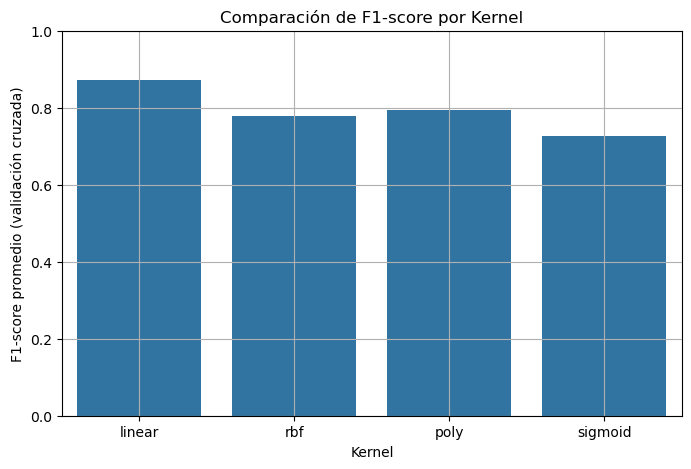

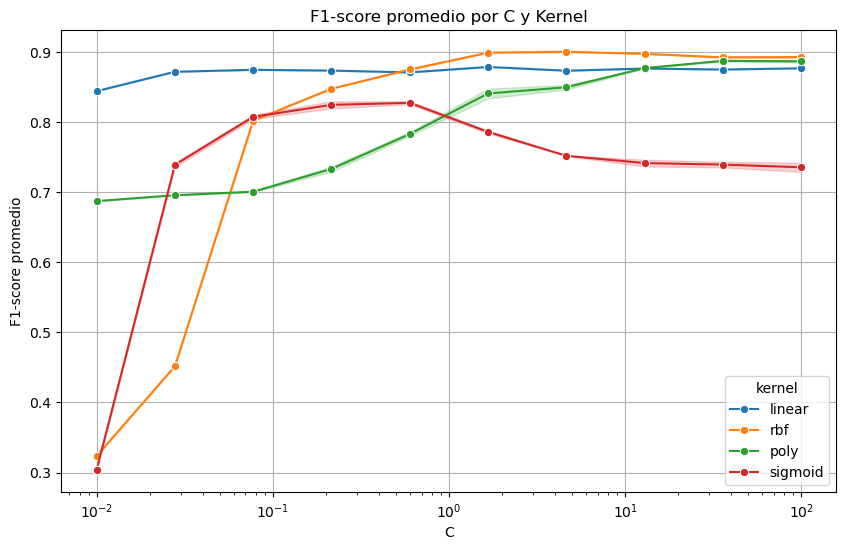

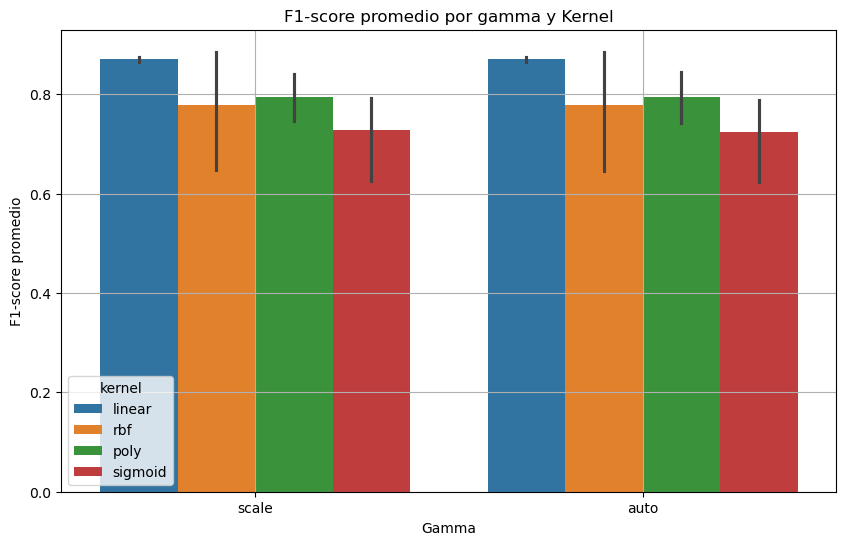

In [8]:
# Crear DataFrame a partir de los resultados de GridSearchCV
df_results = pd.DataFrame(grid.cv_results_)

# Extraer parámetros individuales en columnas
df_results['kernel'] = df_results['param_kernel'].astype(str)
df_results['C'] = df_results['param_C'].astype(float)
df_results['gamma'] = df_results['param_gamma'].astype(str)

# Ver primeros resultados para confirmar
display(df_results[['kernel', 'C', 'gamma', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False))

# Gráfica 1: F1-score promedio por kernel
plt.figure(figsize=(8, 5))
sns.barplot(data=df_results, x='kernel', y='mean_test_score', ci=None)
plt.title('Comparación de F1-score por Kernel')
plt.ylabel('F1-score promedio (validación cruzada)')
plt.xlabel('Kernel')
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.show()

# Gráfica 2: F1-score por C y kernel
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x='C', y='mean_test_score', hue='kernel', marker='o')
plt.title('F1-score promedio por C y Kernel')
plt.xlabel('C')
plt.ylabel('F1-score promedio')
plt.xscale('log')
plt.grid(True)
plt.show()

# Gráfica 3 (opcional): F1-score por gamma y kernel
if df_results['gamma'].nunique() > 1:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_results, x='gamma', y='mean_test_score', hue='kernel')
    plt.title('F1-score promedio por gamma y Kernel')
    plt.xlabel('Gamma')
    plt.ylabel('F1-score promedio')
    plt.grid(True)
    plt.show()


## 4. Metricas

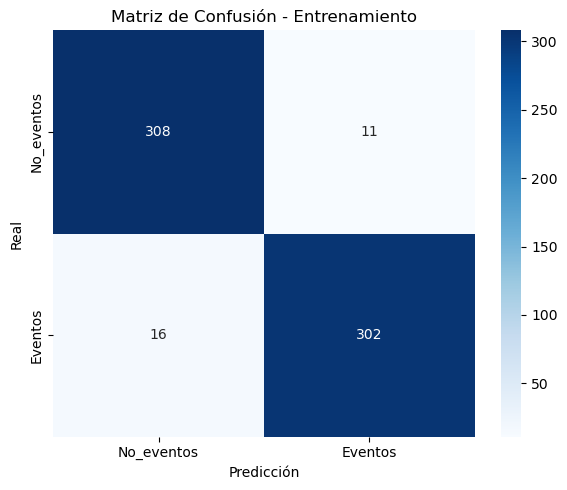


📊 Métricas para Entrenamiento:

Accuracy:          0.9576
Precision (w):     0.9577
Recall (macro):    0.9576
F1-Score:          0.9572
F1-Score (w):      0.9576
F1-Score (macro):  0.9576
F1-Score (micro):  0.9576

Reporte por clase:

              precision    recall  f1-score   support

  No_eventos       0.95      0.97      0.96       319
     Eventos       0.96      0.95      0.96       318

    accuracy                           0.96       637
   macro avg       0.96      0.96      0.96       637
weighted avg       0.96      0.96      0.96       637



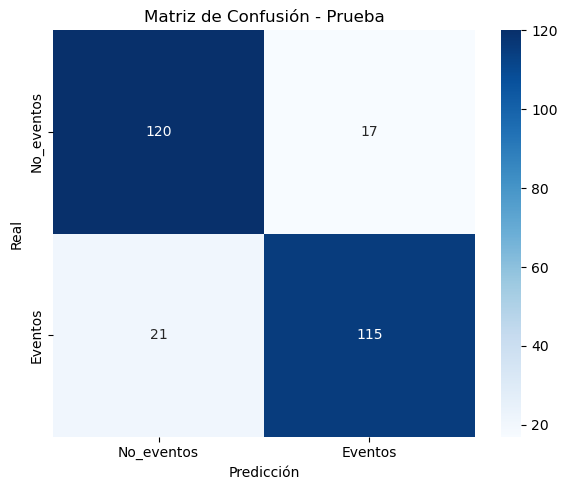


📊 Métricas para Prueba:

Accuracy:          0.8608
Precision (w):     0.8611
Recall (macro):    0.8608
F1-Score:          0.8582
F1-Score (w):      0.8608
F1-Score (macro):  0.8608
F1-Score (micro):  0.8608

Reporte por clase:

              precision    recall  f1-score   support

  No_eventos       0.85      0.88      0.86       137
     Eventos       0.87      0.85      0.86       136

    accuracy                           0.86       273
   macro avg       0.86      0.86      0.86       273
weighted avg       0.86      0.86      0.86       273



In [9]:
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# Función para graficar matriz de confusión
def graficar_matriz_confusion(y_true, y_pred, titulo):
    cm = confusion_matrix(y_true, y_pred)
    etiquetas = ['No_eventos', 'Eventos']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=etiquetas, yticklabels=etiquetas)
    plt.title(f'Matriz de Confusión - {titulo}')
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


mejor_modelo = grid.best_estimator_

# --- Predicción para entrenamiento ---
y_train_pred = mejor_modelo.predict(X_train)
y_test_pred = mejor_modelo.predict(X_test)

# --- Función para imprimir métricas ---
def imprimir_metricas(y_real, y_predicho, conjunto="Desconocido"):
    print(f"\n📊 Métricas para {conjunto}:\n")
    print(f"Accuracy:          {accuracy_score(y_real, y_predicho):.4f}")
    print(f"Precision (w):     {precision_score(y_real, y_predicho, average='weighted'):.4f}")
    print(f"Recall (macro):    {recall_score(y_real, y_predicho, average='macro'):.4f}")
    print(f"F1-Score:          {f1_score(y_real, y_predicho):.4f}")
    print(f"F1-Score (w):      {f1_score(y_real, y_predicho, average='weighted'):.4f}")
    print(f"F1-Score (macro):  {f1_score(y_real, y_predicho, average='macro'):.4f}")
    print(f"F1-Score (micro):  {f1_score(y_real, y_predicho, average='micro'):.4f}")
    print("\nReporte por clase:\n")
    print(classification_report(y_real, y_predicho, target_names=['No_eventos', 'Eventos']))

# --- Graficar matrices de confusión ---
graficar_matriz_confusion(y_train, y_train_pred, "Entrenamiento")
# --- Imprimir métricas para entrenamiento y prueba ---
imprimir_metricas(y_train, y_train_pred, "Entrenamiento")

# --- Graficar matrices de confusión ---
graficar_matriz_confusion(y_test, y_test_pred, "Prueba")
# --- Imprimir métricas para entrenamiento y prueba ---
imprimir_metricas(y_test, y_test_pred, "Prueba")


## 5. Curva de desempeño

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Mejores parámetros: {'C': 4.6415888336127775, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor F1-score: 0.9012903343402494


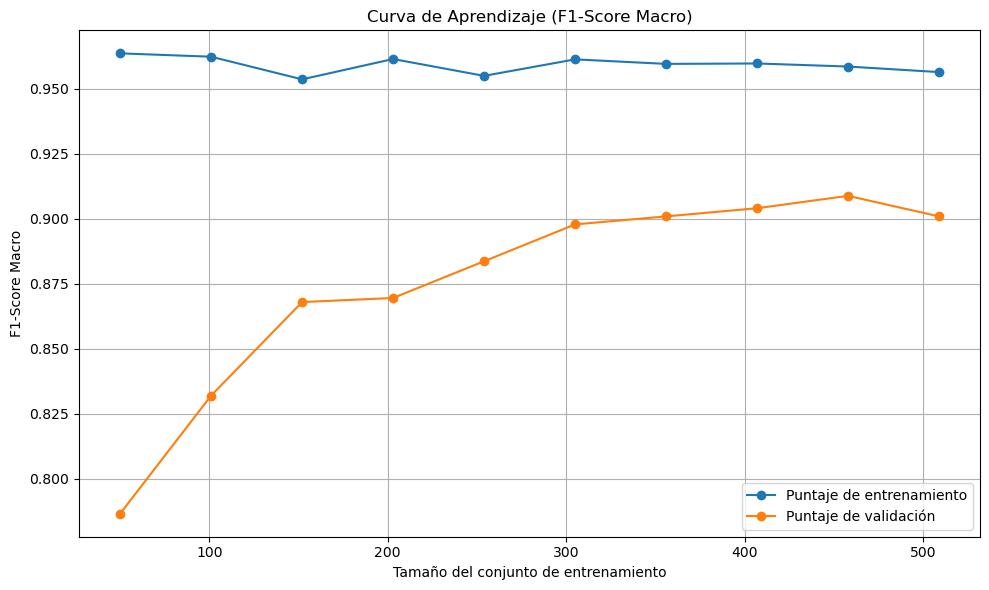

In [11]:
from sklearn.model_selection import learning_curve

grid.fit(X_train, y_train)
print("Mejores parámetros:", grid.best_params_)
print("Mejor F1-score:", grid.best_score_)

# Curva de aprendizaje
best_model = grid.best_estimator_
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train,
    cv=5,
    scoring='f1_macro',  # o el que estés usando
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Puntaje de entrenamiento')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Puntaje de validación')
plt.title('Curva de Aprendizaje (F1-Score Macro)')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('F1-Score Macro')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()
